# A3 - Classical ising model

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/source/en/A003-LargeScaleMC.ipynb)

In this section, we explain how to use core interface (core Python interface) of OpenJij and demonstrate simple calculation.

Core interface is lower layer API than tutorials in previous section. It is assumed that the target reader has done though the previous OpenJij tutorials and is familiar with terms such as ising models and MonteCarlo methods.

We envision a readership with the following objectives.

* want to use OpenJij not only for optimization problem but also for more specialized application such as sampling and reserach activity.
* want to set annealing schedules and directly improve the algorithms used.

In [1]:
import cxxjij.graph as G
# set problem size N = 100
N = 100

graph = G.Dense(N)
# for sparse, use the following
#graph = G.Sparse(N)

We set $J_{ij}, h_i$. In this time, we set the value generated from the Gauss distribution with a mean of 0 and a standard deviation of 1.

In [ ]:
!pip install numpy # use numpy for random number generation

In [3]:
import numpy as np
mu, sigma = 0, 1

for i in range(N):
    for j in range(N):
        # to avoid a large Jij value, normalize in 1/N
        graph[i,j] = 0 if i == j else np.random.normal()/N

for i in range(N):
    graph[i] = np.random.normal()/N

For longitudinal magnetic fields, both `graph[i]` and `graph[i,i]` can be used to access it. In addition, by definition of ising model, $J_{ij}$ and $J_{ji}$ are automatically the same value. Let us try output as follows.

In [4]:
graph[20] = 0.5
print(graph[20,20])
print(graph[20])
graph[12,34] = -0.6
print(graph[12,34])
print(graph[34,12])

0.5
0.5
-0.6
-0.6


## Set System

Next, we define system for calculation. We can choose classcal ising model or transverse magnetic field ising model or other models.

In order to create system of classical ising model, we choose `system.make_classical_ising`.

In [5]:
import cxxjij.system as S

mysystem = S.make_classical_ising(graph.gen_spin(), graph)

The first argument is randomly generated spins, and the second is the Graph. We can make a system of classical ising model with an initial spin configuration of `graph.gen_spin`. 

We can access system directly and can read values.

In [6]:
print(mysystem.spin)

[ 1. -1.  1.  1. -1.  1.  1.  1. -1. -1. -1. -1.  1. -1.  1.  1. -1. -1.
 -1. -1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1. -1.
 -1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.
 -1. -1.  1. -1. -1.  1. -1. -1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.
  1.  1. -1. -1.  1. -1. -1. -1.  1. -1.  1.]


Various other systems including classcal ising models are available, which can be used for different purpose. A method of initialization differs slightly depending on the system to be used. We will introduce this later.

## Run algorithms -Updater, Algorithm-

After definition of System, we choose Updater and run Algorithm.

### Updater

There are certain updaters that can be used for the System. There are two main Updater for classical ising model, 

- [SingleSpinFlip](https://github.com/OpenJij/OpenJij/blob/ec41aecfbac7e4c895e1e7a1718f06eb7ffae0ba/src/updater/single_spin_flip.hpp#L40) (Update one spin at a time using the Metropilis Hastings method)
- [SwendsenWang](https://github.com/OpenJij/OpenJij/blob/ec41aecfbac7e4c895e1e7a1718f06eb7ffae0ba/src/updater/swendsen_wang.hpp#L45) (Cluster update scheme using SwendsenWang method)

### Algorithm

Algorithm needs a **schedule list** to be executed. First, we begin with making schedule list.

#### Schedule list

Schedule list is a list of `(parameters, the number of MonteCarlo steps)`. The value you enter in the parameter part depends on the system. For example, in the case of classical ising model, parameter is the inverse of the temperature, $\beta$. Let's take a look at the settings as follows.

In [7]:
schedule_list = [(0.01, 10),(10, 80),(0.1, 30)]

In above setting, 10 MonteCarlo steps at an inverse temperature $\beta=0.01$, 80 steps at $\beta=10$, 30 steps at $\beta=0.1$, for total of 120 MonteCarlo steps.
Since the inverse temperature is often increased by the geometric series, it is more convenient to use `make_classical_schedule_list` in `utility` as follows.

In [8]:
import cxxjij.utility as U
schedule_list = U.make_classical_schedule_list(0.1, 50, 20, 10)
print(schedule_list)

[((beta: 0.100000) mcs: 20), ((beta: 0.199474) mcs: 20), ((beta: 0.397897) mcs: 20), ((beta: 0.793701) mcs: 20), ((beta: 1.583223) mcs: 20), ((beta: 3.158114) mcs: 20), ((beta: 6.299605) mcs: 20), ((beta: 12.566053) mcs: 20), ((beta: 25.065966) mcs: 20), ((beta: 50.000000) mcs: 20)]


In above example, we set calculations are performed in 20 steps each, varying the temperature in 10 steps from $\beta=0.1$ to $\beta=50$.

#### Run Algorithm

Next, we run Algorithm. By writing `Algorithm_[Updater]_run`, the calculation is performed in the specified Updater. The following example shows SingleSpinFlip.

In [9]:
import cxxjij.algorithm as A
A.Algorithm_SingleSpinFlip_run(mysystem, schedule_list)

The process took an instant but a total of 200 MonteCarlo steps were computed during this time.

> `A.Algorithm_SingleSpinFlip_run(mysystem, seed, schedule_list)`, we can keep the seed fixed. It can be used when we want our results to be reproducible.

We can use callback to get the system at every single MonteCarlo step during Algorithm execution. In the case of classical ising model, we just need to create a funciton with a system and a parameter (inverse temperature) as arguments.

The following example shows callback which record energy values.

In [10]:
energies = []

def callback_log_energy(system, beta):
    # graph is defined in Graphe module before
    energies.append(graph.calc_energy(system.spin))

We execute same Algorithm with this callback.

In [11]:
# we take long schedule (a total of 20000 MonteCarlo step)
schedule_list = U.make_classical_schedule_list(0.1, 50, 200, 100)
A.Algorithm_SingleSpinFlip_run(mysystem, schedule_list, callback_log_energy)

Let us make the energy of the recorded system with MonteCarlo steps on x-axis, and energy on y-axis, we get following figure.

In [ ]:
!pip install matplotlib

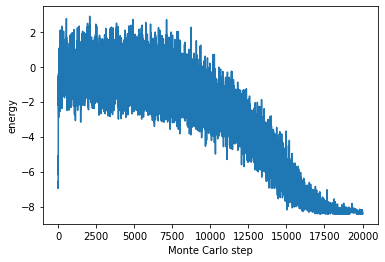

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(len(energies)), energies)
plt.xlabel('Monte Carlo step')
plt.ylabel('energy')
plt.show()

We can see that the energy is gradually getting lower and lower as the annealing progresses. It is useful when we want to know how to system looks like while Algorighm is running.

## Get result -Result-

We get spin sequence of calculation result using `result.get_solution`. In the case of classical ising model, we get it from `mysystem.spin` directly. However, `result.get_solution` is a useful method to get spin sequence from other systems.

In [13]:
import cxxjij.result as R
print(R.get_solution(mysystem))

[1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1]


This sequence is result of execution. It is expected to be in Hamiltonian groud state (or close to ground state)

## C++ core interface

We can do almost the same things with C++ core interface as above, with a few differences. We note two points the following. 

- need to input random number generator (C++11 random) to argument of seed.
- in the Graph class, the access to $J_{ij}, h_i$ is slightly different.

The content so far can be described in C++ core interface as follows.

```cpp
#include <graph/all.hpp>
#include <system/all.hpp>
#include <updater/all.hpp>
#include <algorithm/all.hpp>
#include <result/all.hpp>
#include <utility/schedule_list.hpp>
#include <utility/random.hpp>
#include <random>

#include <iostream>

using namespace openjij;

int main(void){

    //generate dense graph with size N=100
    constexpr std::size_t N = 100;
    auto dense = graph::Dense<double>(N);

    //generate random engine
    auto rand_engine = std::mt19937(0x1234);
    //of course you can specify another random generator that is compatible with C++ random generator, say utility::Xorshift,
    //auto rand_engine = utility::Xorshift(0x1234);
    
    //Gaussian distribution
    auto gauss = std::normal_distribution<>{0, 1};

    //set interactions
    for(std::size_t i=0; i<N; i++){
        for(std::size_t j=0; j<N; j++){
            dense.J(i, j) = (i == j) ? 0 : gauss(rand_engine)/N;
        }
    }

    //set local fields
    for(std::size_t i=0; i<N; i++){
        dense.h(i) = gauss(rand_engine);
    }

    //create classical Ising system
    auto system = system::make_classical_ising(dense.gen_spin(rand_engine), dense);

    //generate schedule list
    //from beta=0.1 to beta=50, 20 Monte Carlo step for each tempearature, 10 samples
    auto schedule_list = utility::make_classical_schedule_list(0.1, 50, 20, 10);

    //or in the case of classical system, you can specify arbitrary schedules by using a std::vector of utility::Schedule<system::classical_system>
    //std::vector<utility::Schedule<system::classical_system>> schedule_list;
    //utility::Schedule<system::classical_system> schedule;
    //schedule.updater_parameter = {0.01};
    //schedule.one_mc_step = 10; //number of Monte Carlo step per temperature
    //schedule_list.push_back(schedule);
    //
    //schedule.updater_parameter = {10};
    //schedule.one_mc_step = 80; //number of Monte Carlo step per temperature
    //schedule_list.push_back(schedule);
    //
    //schedule.updater_parameter = {0.1};
    //schedule.one_mc_step = 30; //number of Monte Carlo step per temperature
    //schedule_list.push_back(schedule); //schedule_list -> [(0.01, 10), (10, 80), (0.1, 30)]


    //do annealing (updater: SingleSpinFlip)
    algorithm::Algorithm<updater::SingleSpinFlip>::run(system, rand_engine, schedule_list);

    //show spins
    std::cout << "The result spins are [";
    for(auto&& elem : result::get_solution(system)){
        std::cout << elem << " ";
    }

    std::cout << "]" << std::endl;
}

```